# Import Libraries or dependencies

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import shutil
import matplotlib.pyplot as plt
import datetime

# Load Dataset and Vizualize

In [3]:
# Dataset 1- https://www.kaggle.com/datasets/umangjjw/tinyimagenet200/data(64 by 64)
# Dataset 2 - https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000/data (128 by 128)

## Transfer images to new file


In [ ]:
#Image_label
     #-Images

In [29]:
path_image = os.path.join("tiny-imagenet-200","train") 

In [30]:
os.path.exists(path_image)

True

In [31]:
data_dir = pathlib.Path(path_image)

In [39]:
list(data_dir.glob("*/*/*.JPEG"))

[WindowsPath('C:/Users/emryz/OneDrive/Desktop/ML/computer_Vision/PaperCode/ImageNet Code Implementation/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG'),
 WindowsPath('C:/Users/emryz/OneDrive/Desktop/ML/computer_Vision/PaperCode/ImageNet Code Implementation/tiny-imagenet-200/train/n01443537/images/n01443537_1.JPEG'),
 WindowsPath('C:/Users/emryz/OneDrive/Desktop/ML/computer_Vision/PaperCode/ImageNet Code Implementation/tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG'),
 WindowsPath('C:/Users/emryz/OneDrive/Desktop/ML/computer_Vision/PaperCode/ImageNet Code Implementation/tiny-imagenet-200/train/n01443537/images/n01443537_100.JPEG'),
 WindowsPath('C:/Users/emryz/OneDrive/Desktop/ML/computer_Vision/PaperCode/ImageNet Code Implementation/tiny-imagenet-200/train/n01443537/images/n01443537_101.JPEG'),
 WindowsPath('C:/Users/emryz/OneDrive/Desktop/ML/computer_Vision/PaperCode/ImageNet Code Implementation/tiny-imagenet-200/train/n01443537/images/n01443537_102.JPEG'),
 Wi

In [52]:
list(data_dir.glob("*/*/*.JPEG"))[200].name.split("_")

['n01443537', '279.JPEG']

In [42]:
path_train_dir = os.path.join("train_images")

In [46]:
new_label_path = os.path.join(path_train_dir,"n01443537")
os.makedirs(new_label_path)

In [3]:
NUM_LABELS = 200
LABELS = []
PATH_OLDER_TRAIN_IMAGES = os.path.join("tiny-imagenet-200","train") 
DIR_OLDER_TRAIN_IMAGES = pathlib.Path(PATH_OLDER_TRAIN_IMAGES)
NEW_TRAIN_IMAGES_DIR = os.path.join("train_images")
IMG_HEIGHT = 64
IMG_WIDTH=64
BATCHSIZE=16

In [ ]:
# for i in range(NUM_LABELS):
for image_path in data_dir.glob("*/*/*.JPEG"):
    image_name = image_path.name # get image name with extension
    label_name = image_name.split("_")[0] # get name without extension
    destination_path = os.path.join(NEW_TRAIN_IMAGES_DIR,label_name) # path to destination
    if label_name not in LABELS: # if new label, add to labels
        os.makedirs(destination_path) # create new destination path with label_name
        LABELS.append(label_name)
    shutil.copy(image_path,destination_path)

## load Dateset 

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(NEW_TRAIN_IMAGES_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCHSIZE)

Found 10000 files belonging to 20 classes.
Using 8000 files for training.


In [15]:
class_name = dataset.class_names

In [74]:
next(dataset.take(1).as_numpy_iterator())[1]

array([13, 19, 18,  4, 16,  5, 17,  5,  2,  7,  7, 11,  3,  8, 19,  6])

## Vizualize Dataset

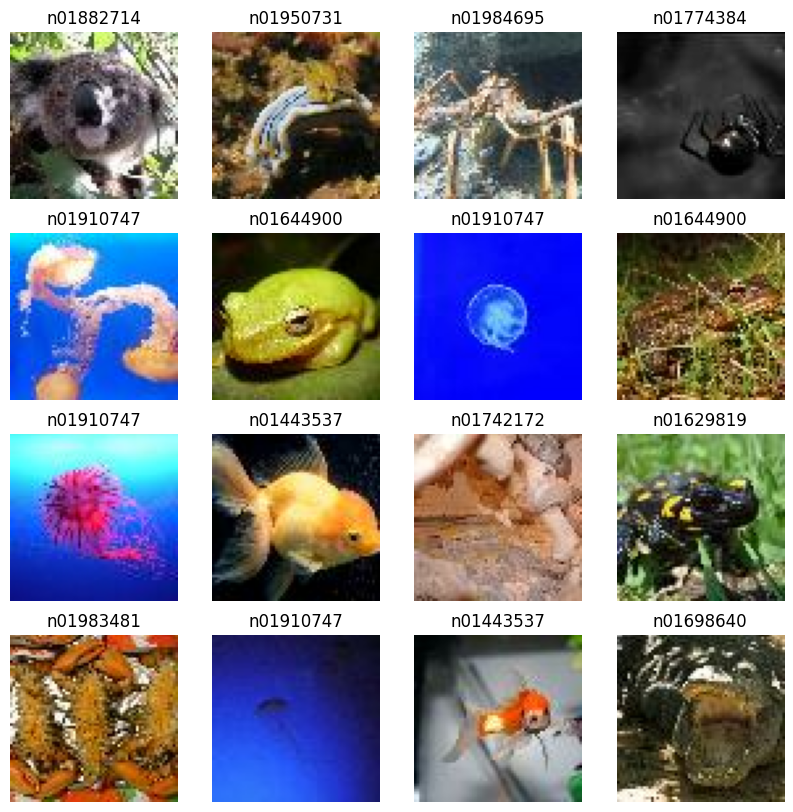

In [216]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_name[labels[i]])
        plt.axis("off")

In [5]:
def resize_rescale(image,label):
    image = tf.image.resize(image, [64,64])
    norm_image = image / 255
    return norm_image,label

In [6]:
train_ds = dataset.map(resize_rescale).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
next(train_ds.take(1).as_numpy_iterator())[0].dtype

dtype('float32')

# Build Model

In [221]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, Dropout,MaxPool2D

In [10]:
class Local_Response_Normalization_Layer(tf.keras.layers.Layer):
    def __init__(self,depth_radius=5, bias=1.0, alpha=1e-4, beta=0.75,**kwargs):
        super(Local_Response_Normalization_Layer, self).__init__(**kwargs)
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta

    def call(self,inputs):
        return tf.nn.local_response_normalization(inputs,depth_radius=5, bias=1.0, alpha=1e-4, beta=0.75)

    def get_config(self):
        # Include layer parameters in configuration for saving and loading
        config = super(Local_Response_Normalization_Layer, self).get_config()
        config.update({
            'depth_radius': self.depth_radius,
            'bias': self.bias,
            'alpha': self.alpha,
            'beta': self.beta
        })
        return config

In [223]:
def build_alexnet_mini():
    model = Sequential()

    ## CONVULUTION LAYERS
    #block 1
    model.add(Conv2D(32,5,padding="same",input_shape=(64,64,3),activation="relu"))
    model.add(Local_Response_Normalization_Layer()) # mechanism creates lateral inhibition
    model.add(MaxPool2D(3,strides=2,padding="same"))

    #block 2
    model.add(Conv2D(64,5,padding="same",activation="relu"))
    model.add(Local_Response_Normalization_Layer())
    model.add(MaxPool2D(3,strides=2,padding="same"))

    #block 3
    model.add(Conv2D(128,3,padding="same",activation="relu"))

    #block 4
    model.add(Conv2D(128,3,padding="same",activation="relu"))

    #block 5
    model.add(Conv2D(64,3,padding="same",activation="relu"))
    model.add(MaxPool2D(3,strides=2,padding="same"))

    model.add(Flatten())

    ## FULLY CONNECTED LAYERS
    model.add(Dense(1024,activation="relu"))
    Dropout(0.5)
    model.add(Dense(512,activation="relu"))
    Dropout(0.5)
    model.add(Dense(20,activation="softmax"))
    
    return model

In [224]:
ALEXNET_MINI = build_alexnet_mini()
ALEXNET_MINI.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 local__response__normalizat  (None, 64, 64, 32)       0         
 ion__layer (Local_Response_                                     
 Normalization_Layer)                                            
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 local__response__normalizat  (None, 32, 32, 64)       0         
 ion__layer_1 (Local_Respons                            

In [230]:
log_dir = "logs/fit/" + "ALEXNET_MINI2"
os.makedirs(log_dir)

In [231]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [241]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,decay=0.0005)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics=["accuracy"]
ALEXNET_MINI.compile(optimizer=optimizer,loss=loss,metrics=metrics)

# Train Model

In [242]:
hist = ALEXNET_MINI.fit(train_ds, epochs=35,verbose=1,callbacks=[tensorboard_callback])

Epoch 1/35
500/500 [==============================] - 9s 14ms/step - loss: 2.8891 - accuracy: 0.0990
Epoch 2/35
500/500 [==============================] - 7s 14ms/step - loss: 2.6603 - accuracy: 0.1771
Epoch 3/35
500/500 [==============================] - 7s 14ms/step - loss: 2.4654 - accuracy: 0.2412
Epoch 4/35
500/500 [==============================] - 7s 14ms/step - loss: 2.2934 - accuracy: 0.2934
Epoch 5/35
500/500 [==============================] - 7s 14ms/step - loss: 2.1061 - accuracy: 0.3503
Epoch 6/35
500/500 [==============================] - 7s 14ms/step - loss: 1.8887 - accuracy: 0.4130
Epoch 7/35
500/500 [==============================] - 22s 43ms/step - loss: 1.7331 - accuracy: 0.4613
Epoch 8/35
500/500 [==============================] - 44s 88ms/step - loss: 1.5254 - accuracy: 0.5265
Epoch 9/35
500/500 [==============================] - 44s 88ms/step - loss: 1.3158 - accuracy: 0.5907
Epoch 10/35
500/500 [==============================] - 44s 88ms/step - loss: 1.1356 - ac

In [239]:
data = next(train_ds.take(1).as_numpy_iterator())

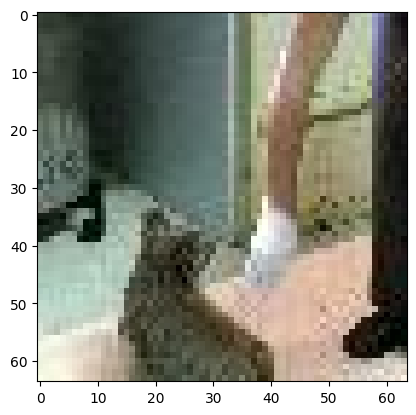

In [240]:
plt.imshow(data[0][15])

In [220]:
class_name[np.argmax(ALEXNET_MINI.predict(np.expand_dims(data[0][15],axis=0)))]

1/1 [==============================] - 0s 68ms/step


'n01855672'

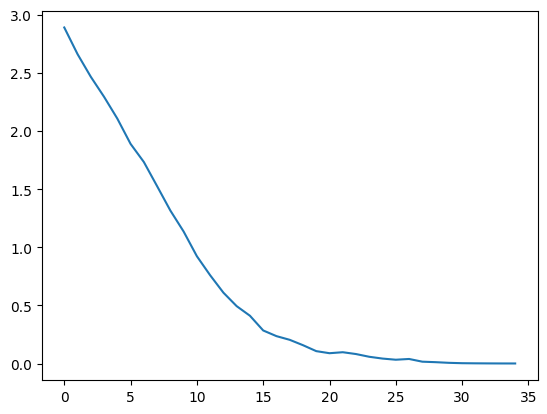

In [248]:
plt.plot(hist.history['loss'])

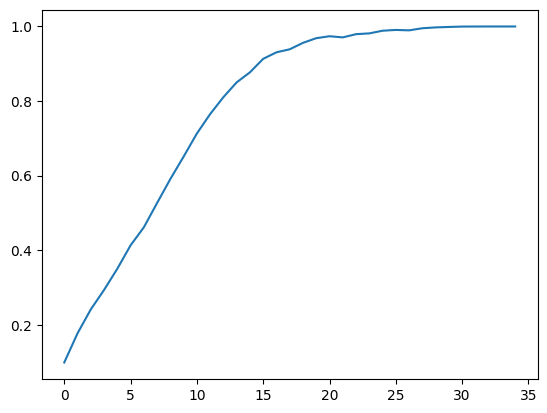

In [249]:
plt.plot(hist.history['accuracy'])

In [246]:
hist.history

{'loss': [2.8891093730926514,
  2.6603100299835205,
  2.4654438495635986,
  2.2933812141418457,
  2.1060900688171387,
  1.8887265920639038,
  1.7331321239471436,
  1.5254161357879639,
  1.3157958984375,
  1.13555109500885,
  0.9232242703437805,
  0.7597729563713074,
  0.610149621963501,
  0.4942511320114136,
  0.4118238687515259,
  0.28531473875045776,
  0.23662687838077545,
  0.20490123331546783,
  0.15878519415855408,
  0.10773233324289322,
  0.08988059312105179,
  0.09841620922088623,
  0.08264985680580139,
  0.05916322395205498,
  0.04375821352005005,
  0.033890578895807266,
  0.04039178416132927,
  0.017059138044714928,
  0.012872510589659214,
  0.007237215060740709,
  0.004060670267790556,
  0.0029715225100517273,
  0.0022896653972566128,
  0.0018550035310909152,
  0.0016578605864197016],
 'accuracy': [0.0989999994635582,
  0.1771250069141388,
  0.24124999344348907,
  0.2933749854564667,
  0.3502500057220459,
  0.4129999876022339,
  0.4612500071525574,
  0.5264999866485596,
  0.5

## Save Model and Laod Model

## Old Save

In [218]:
ALEXNET_MINI.save("ALEX_NET_MINI.h5")

In [12]:
loaded_model = tf.keras.models.load_model("ALEX_NET_MINI2.h5", custom_objects={'Local_Response_Normalization_Layer': Local_Response_Normalization_Layer})

## New Save

In [8]:
ALEXNET_MINI.save("ALEX_NET_MINI2.h5")

NameError: name 'ALEXNET_MINI' is not defined

In [13]:
model = loaded_model

# Inference

# Single Prediction

In [27]:
class_value = []
with open("words.txt","r") as f:
    class_value = f.readlines()

In [28]:
class_value

['n00001740\tentity\n',
 'n00001930\tphysical entity\n',
 'n00002137\tabstraction, abstract entity\n',
 'n00002452\tthing\n',
 'n00002684\tobject, physical object\n',
 'n00003553\twhole, unit\n',
 'n00003993\tcongener\n',
 'n00004258\tliving thing, animate thing\n',
 'n00004475\torganism, being\n',
 'n00005787\tbenthos\n',
 'n00005930\tdwarf\n',
 'n00006024\theterotroph\n',
 'n00006150\tparent\n',
 'n00006269\tlife\n',
 'n00006400\tbiont\n',
 'n00006484\tcell\n',
 'n00007347\tcausal agent, cause, causal agency\n',
 'n00007846\tperson, individual, someone, somebody, mortal, soul\n',
 'n00015388\tanimal, animate being, beast, brute, creature, fauna\n',
 'n00017222\tplant, flora, plant life\n',
 'n00019046\tnative\n',
 'n00019128\tnatural object\n',
 'n00019613\tsubstance\n',
 'n00020090\tsubstance\n',
 'n00020827\tmatter\n',
 'n00021265\tfood, nutrient\n',
 'n00021734\tnutrient\n',
 'n00021939\tartifact, artefact\n',
 'n00022903\tarticle\n',
 'n00023100\tpsychological feature\n',
 'n0002

In [34]:
class_label = {}
for item in class_value:
    key = item.split("\t")[0]
    value = item.split("\t")[1][:-1]
    class_label[key] = value

Text(0.5, 1.0, 'goldfish, Carassius auratus')

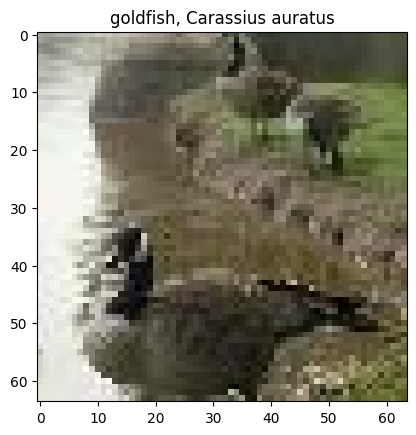

In [36]:
plt.imshow(next(dataset.as_numpy_iterator())[0][0].astype(np.uint8))
plt.title(class_label[class_name[next(dataset.as_numpy_iterator())[1][0]]])

In [81]:
next(dataset.as_numpy_iterator())[1][0]

5

In [37]:
class_label[class_name[np.argmax(loaded_model.predict(np.expand_dims(next(dataset.as_numpy_iterator())[0][0],axis=0)))]]

1/1 [==============================] - 5s 5s/step


'bullfrog, Rana catesbeiana'

## Multiple Prediction

In [39]:
images_to_predict = next(dataset.as_numpy_iterator())

In [192]:
class_label[class_name[labels[1]]][]

'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus'

In [46]:
model.predict()

(16, 64, 64, 3)

In [48]:
model_predictions = loaded_model.predict(images)

1/1 [==============================] - 0s 438ms/step


In [49]:
model_predicted_labels = [class_label[class_name[np.argmax(prediction)]] for prediction in model_predictions]

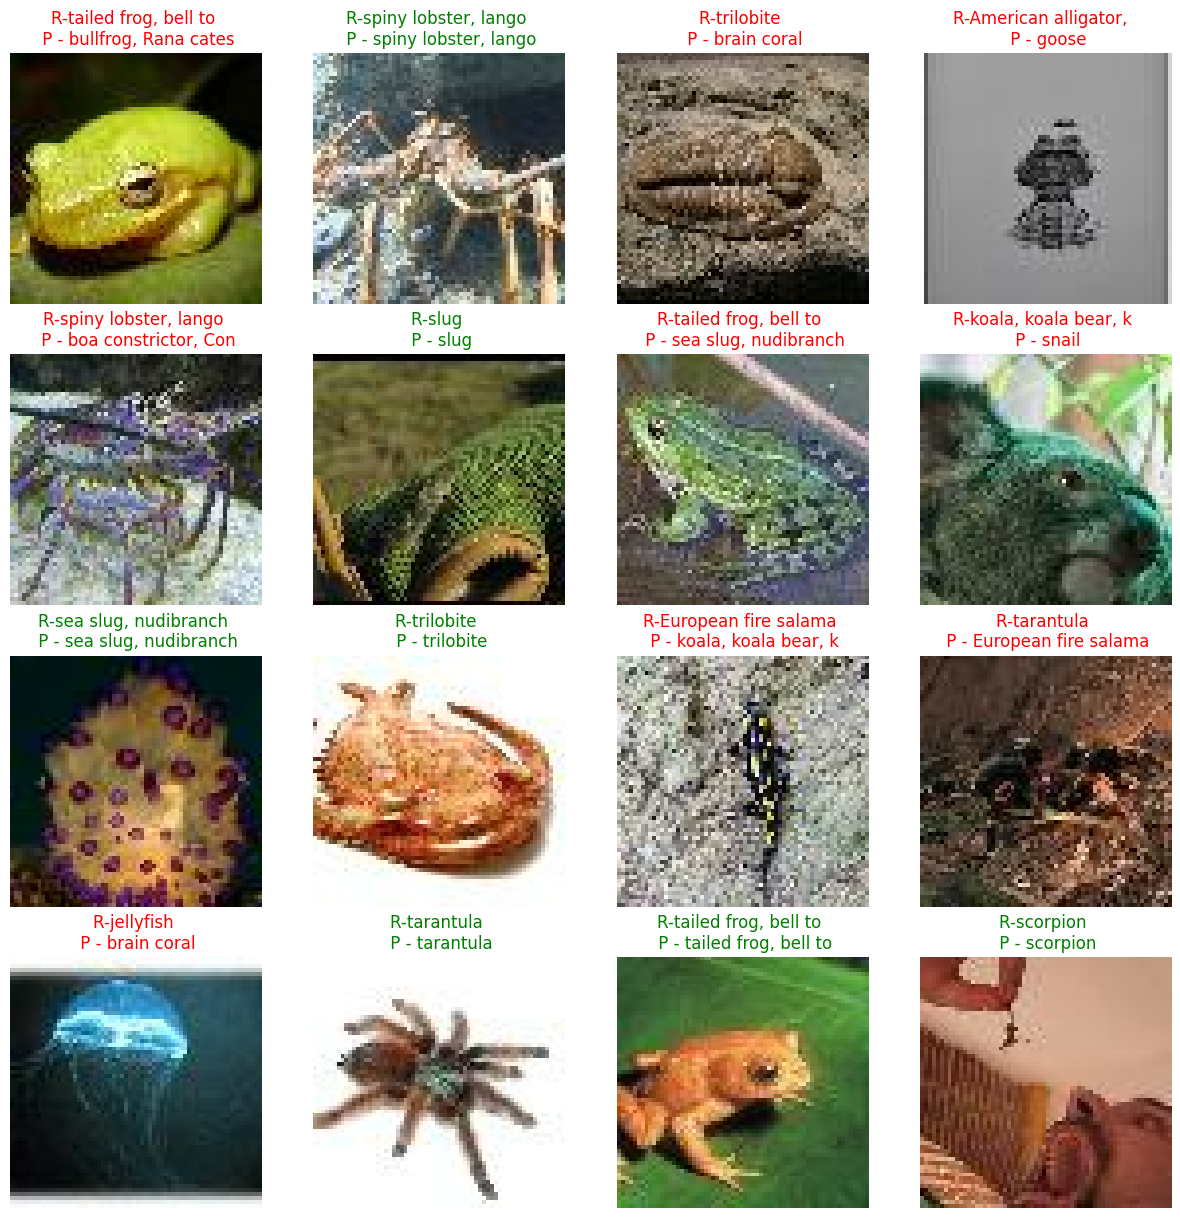

In [53]:
plt.figure(figsize=(15, 15))
images, labels = images_to_predict
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].astype("uint8"))
    real = class_label[class_name[labels[i]]][:20]
    predicted = model_predicted_labels[i][:20]
    if predicted == real:
        plt.title("{}-{} \n {} - {}".format("R",real,"P",predicted),color="green")
    else:
        plt.title("{}-{} \n {} - {}".format("R",real,"P",predicted),color="red")
    plt.axis("off")

1/1 [==============================] - 0s 21ms/step


In [210]:
model_predicted_labels

['centipede',
 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'sea slug, nudibranch',
 'black widow, Latrodectus mactans',
 'brain coral',
 'slug',
 'snail',
 'black widow, Latrodectus mactans',
 'jellyfish',
 'boa constrictor, Constrictor constrictor',
 'centipede',
 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'centipede',
 'boa constrictor, Constrictor constrictor']